In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import traintest as tt
from plot_utils import *
import models
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from sklearn import mixture, preprocessing, datasets
from copy import deepcopy
%load_ext skip_kernel_extension
%load_ext autoreload
%autoreload 2

In [2]:
# Generate dataset
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df=(df-df.min())/(df.max()-df.min()) # normalize [0,1]
df['labels'] = labels
data = torch.tensor(df[['feature_1', 'feature_2']].to_numpy(), dtype=torch.float) 
device=torch.device('cuda:0')

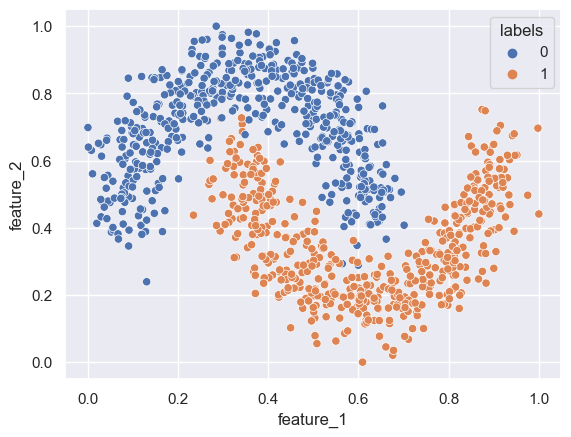

In [3]:
sns.set_theme()
def moons_scatter(ax=None):
    if ax:
        sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels, ax=ax)
    else:
        sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)
moons_scatter()

In [4]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
zs = gmm.find_solution(data,iterate=True, collect_z=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [5]:
df2 = pd.DataFrame(gmm.mu.detach(), columns=['feature_1', 'feature_2'])
df2['labels'] = ['gmm_center']*n_centers

In [6]:
# make grid for contour
x = y = np.arange(-.03, 1.03, 0.01)
points = []
for xx in x:
    for yy in y:
        points.append([xx, yy])

<Axes: xlabel='feature_1', ylabel='feature_2'>

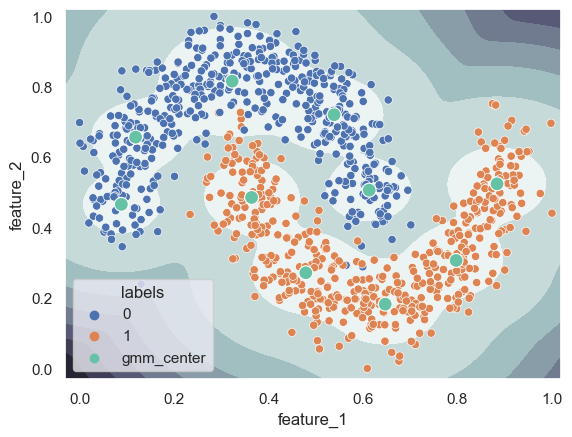

In [7]:
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
plt.contourf(x,y,z, cmap=plt.cm.bone)
moons_scatter()
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)

In [8]:
%%skip True
animate_em(zs,x,y,df)

### MLP Classifier

In [9]:
label = torch.tensor(labels, dtype=torch.int64)
train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

In [10]:
class TwoMoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]
loss = []
acc = []
optimizer = optim.Adam(param_groups)

for epoch in range(200):
    
    l,a,_= tt.train_plain(net.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1)
    loss.append(l)
    acc.append(a)
    if a > .98:
        break # converged

Text(0.5, 0, 'Epoch')

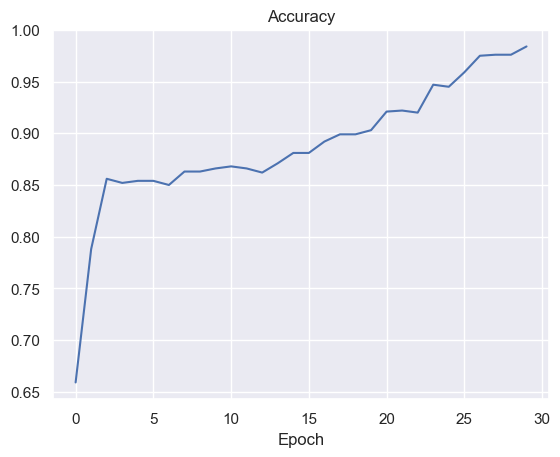

In [11]:
sns.lineplot(acc)
plt.title('Accuracy')
plt.xlabel('Epoch')

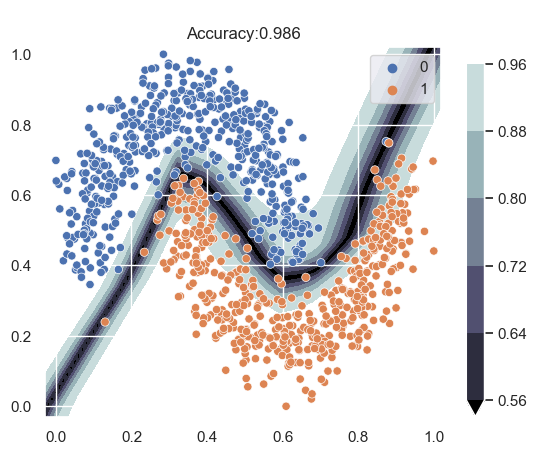

In [12]:
plot_conf(net, data, label, device=device)

### CCU Robust Model Learning

In [13]:
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [14]:
data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000, dtype=torch.int64)


train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)

In [15]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

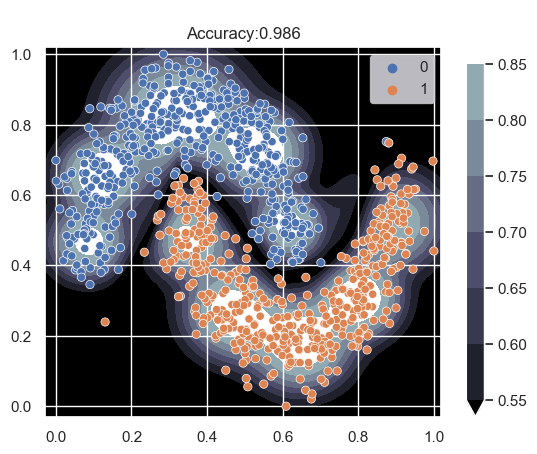

In [16]:
plot_conf(CCU.to(device), data, label, device=device)

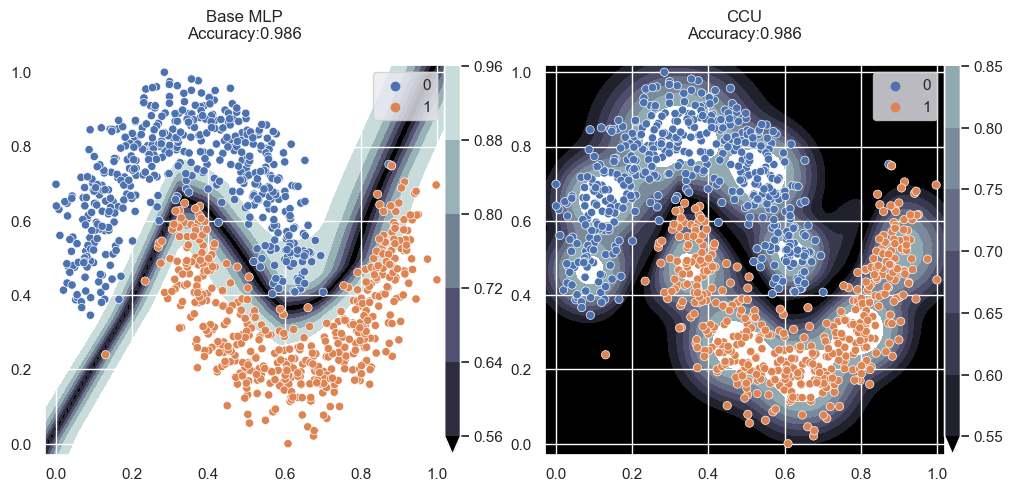

In [17]:
#%%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.87,left=.05,wspace=.25,right=.95)
plot_conf(CCU.base_model.to(device), data, label,
             ax1, device=device, title='Base MLP')
plot_conf(CCU.to(device), data, label,
             ax2, device=device, title='CCU')

# plt.savefig('Base_Vs._CCU_Confidence.png')

In [18]:
gmm.mu.requires_grad_(False) # turn of learning of centers
for epoch in range(100):
    tt.train_CEDA_gmm(CCU, device, train_loader,
                      optimizer, epoch, verbose=-1,
                      noise_loader=train_loader_out)

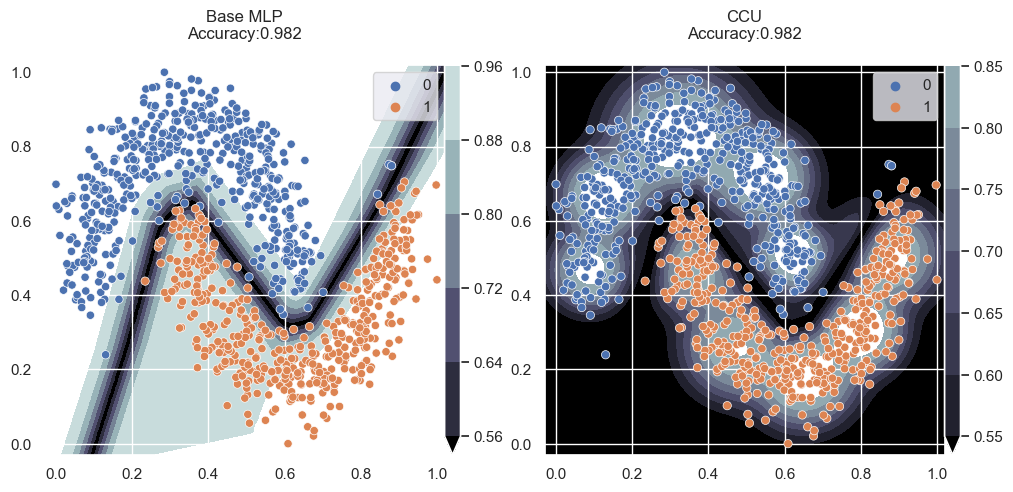

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.87,left=.05,wspace=.25,right=.95)
plot_conf(CCU.base_model.to(device), data, label,
             ax1, device=device, title='Base MLP')
plot_conf(CCU.to(device), data, label,
             ax2, device=device, title='CCU')

## RBFNet Classifier

In [20]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x, p=2, dim=-1):
    return torch.norm(x, p=p, dim=dim)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()


class TwoMoonsRBFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=10,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True)
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [21]:
lr = 0.1
decay = 5e-4

RBFnet = TwoMoonsRBFNet()
param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)
rbf_tracker = [deepcopy(RBFnet.rbf)]
for epoch in range(100):
    loss,acc,_ = tt.train_plain(RBFnet.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
    if acc > .98:
        print('Done training at EPOCH:',epoch)
        break

Done training at EPOCH: 27


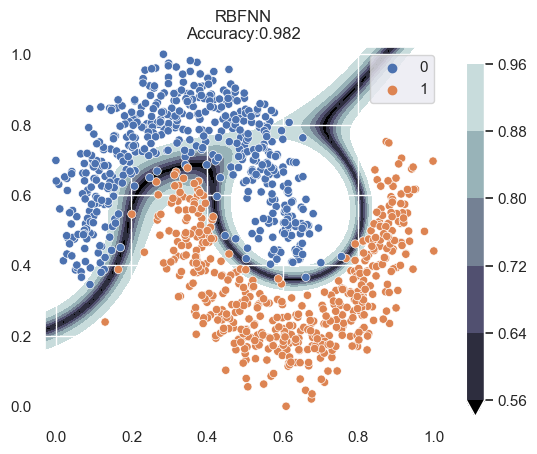

In [22]:
# %%skip True
plot_conf(RBFnet, data, label, device=device, title='RBFNN')
# plt.savefig('RBFNN_conf.png')

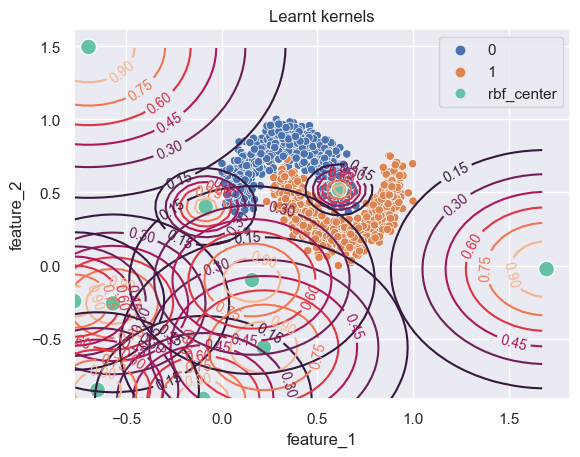

In [23]:
kernel_map(RBFnet.rbf, df)

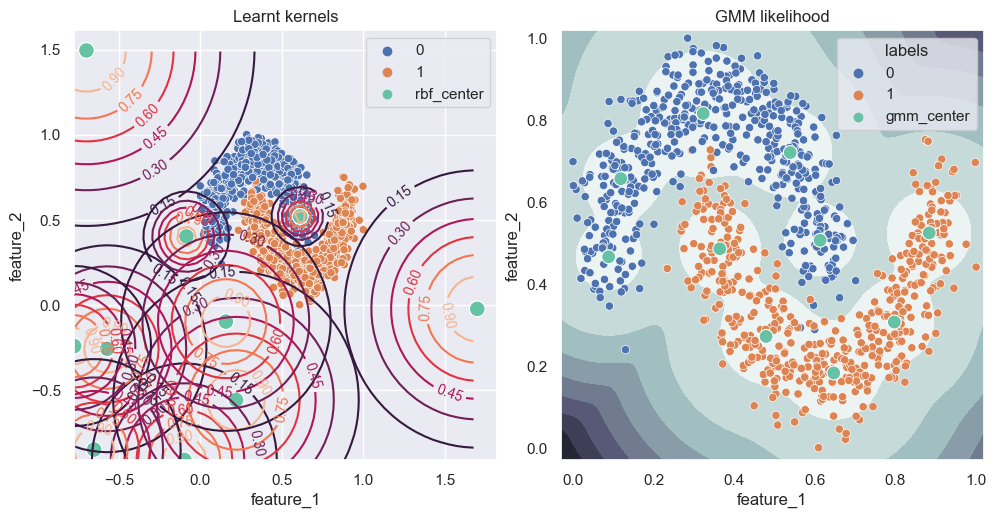

In [24]:
# %%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.95,left=.08,wspace=.15,right=.99)
kernel_map(RBFnet.rbf, df, ax = ax1)
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
cont = ax2.contourf(x,y,z, cmap=plt.cm.bone)
#sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels', ax = ax2)
moons_scatter(ax2)
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100, ax = ax2)
ax2.title.set_text(f'GMM likelihood')
# plt.savefig('RBF_Vs_GMM_Centers.png')

In [25]:
%%skip True
animate_rbf(rbf_tracker, df)

## RBF with CCU (with GMM and RBF seperate)

In [26]:
RBFCCU = models.RobustModel(deepcopy(RBFnet.to(device)), deepcopy(gmm.to(device)), 0.0, dim=2,classes=2)

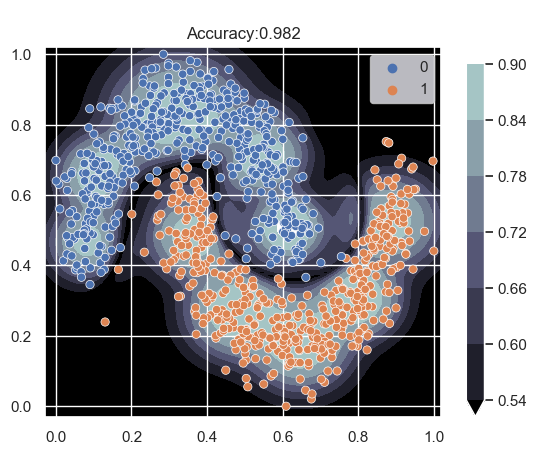

In [27]:
plot_conf(RBFCCU,data, label, device=device)

In [28]:
lr_gmm = 1e-4
param_groups = [{'params':RBFCCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':RBFCCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

In [29]:
gmm.mu.requires_grad_(False) # turn of learning of centers
for epoch in range(100):
    tt.train_CEDA_gmm(RBFCCU, device, train_loader,
                      optimizer, epoch, verbose=-1,
                      noise_loader=train_loader_out)

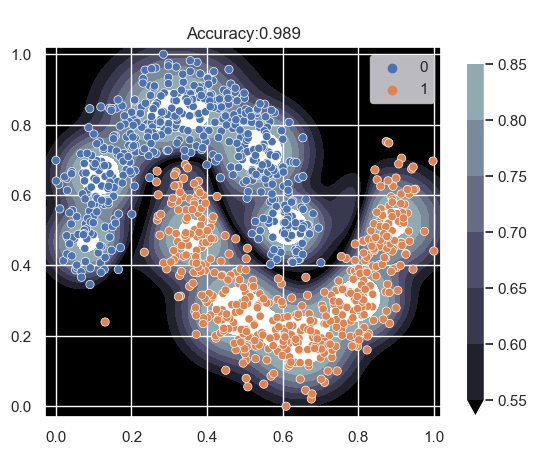

In [30]:
plot_conf(RBFCCU,data, label, device=device)

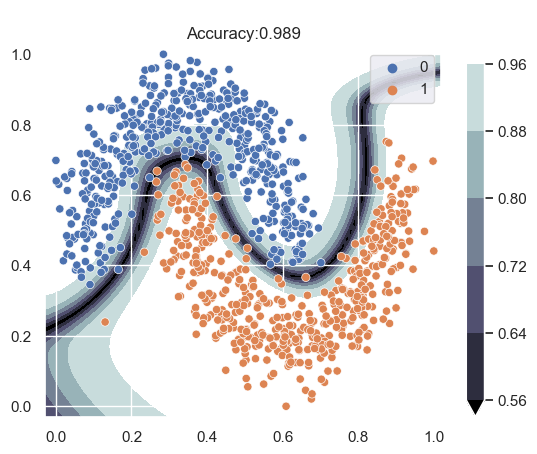

In [31]:
plot_conf(RBFCCU.base_model,data, label, device=device)

### Compare RBF output to GMM output

In [32]:
sample = torch.tensor([[.4,.4],[.7,.8]])
RBFnet.to('cpu')
gmm.to('cpu')

GMM(
  (metric): LpMetric()
)

In [33]:
RBFnet.rbf(sample) # rbf has 10 centers, gives distance from each center row wise

tensor([[ 1.8194e-03,  1.2535e+00, -3.0131e-02, -1.4213e-01,  2.8924e-01,
         -3.4184e-01, -4.9369e-03, -1.3667e-01, -8.5369e-03, -1.0068e-01],
        [ 4.6675e-03,  5.1182e-01, -3.2385e-02,  4.4327e-01,  6.4277e-02,
          4.4564e-02,  7.0257e-04,  3.5801e-01, -3.7130e-03,  3.0405e-01]],
       grad_fn=<SumBackward1>)

In [34]:
rc = RBFnet.rbf.get_kernels_centers
rvar = RBFnet.rbf.get_shapes
rw = RBFnet.rbf.get_weights

In [35]:
RBFnet.rbf(rc)

tensor([[ 1.7789e-03,  4.2620e-01, -4.7513e-04,  1.8627e-01,  5.7166e-02,
         -7.9298e-02,  2.4077e-02,  1.7886e-01, -6.1460e-04,  1.5304e-01],
        [-1.3116e-03,  9.8257e-02, -1.9615e-03,  1.5121e-02,  1.9319e-02,
         -2.8753e-02,  7.7395e-03,  6.2913e-03, -1.4681e-03,  9.1793e-03],
        [ 6.1882e-03, -6.4382e-01, -4.3968e-02,  1.3116e+00, -4.2509e-02,
          3.1042e-01,  1.9996e-02,  1.0371e+00, -5.0858e-03,  9.1197e-01],
        [ 6.5508e-03,  1.7384e+00, -5.3449e-03, -6.6760e-01,  4.7607e-02,
          3.8266e-02, -2.3892e-02, -4.3927e-01,  2.4459e-04, -5.3752e-01],
        [ 3.6477e-03,  1.0824e+00,  3.2825e-03, -9.3771e-02,  1.8510e-01,
         -2.4801e-01,  2.5240e-02, -2.3693e-02, -4.0327e-03, -6.6604e-02],
        [-5.2023e-04, -5.3463e-01, -1.5862e-03,  1.1934e+00, -2.1037e-03,
          1.0967e-02,  1.1106e-02,  9.4367e-01, -3.7421e-03,  8.6351e-01],
        [ 1.5929e-03,  1.3028e-01, -5.4705e-02,  1.1908e+00, -2.4272e-02,
         -7.3895e-03,  2.9863e-0

In [36]:
rc

tensor([[-0.0975, -0.9123],
        [-0.5707, -0.2589],
        [-0.6986,  1.4945],
        [ 1.6989, -0.0245],
        [ 0.2191, -0.5597],
        [-0.0851,  0.4018],
        [ 0.6128,  0.5190],
        [-0.7738, -0.2433],
        [ 0.1569, -0.0989],
        [-0.6516, -0.8510]])

In [37]:
gmm(sample)# gmm has 10 centers, gives value in column for likelihood of each point from sample

tensor([[  0.1357, -25.3910],
        [-10.7160, -18.7221],
        [-21.4459, -54.9488],
        [ -9.0803,  -6.9425],
        [ -1.0530, -33.1965],
        [-23.7532,  -9.8490],
        [-15.6795, -79.0740],
        [-10.0182, -38.9664],
        [-14.3089,  -2.7719],
        [-22.8439, -35.4202]], grad_fn=<SubBackward0>)

In [38]:
gc = gmm.mu.detach()
gvar = gmm.logvar.detach()
gw = gmm.alpha.detach()

In [39]:
gvar.exp()

tensor([0.0040, 0.0023, 0.0032, 0.0086, 0.0047, 0.0050, 0.0030, 0.0048, 0.0039,
        0.0034])

In [40]:
gw.exp()

tensor([0.0849, 0.0697, 0.0778, 0.2084, 0.1135, 0.0914, 0.0552, 0.1157, 0.0971,
        0.0863])

In [41]:
rvar

tensor([2.4328, 2.2680, 1.3364, 1.6909, 1.8303, 5.2836, 7.9901, 2.9321, 2.1473,
        2.5944])

In [42]:
rw.exp()

tensor([[1.0003, 0.9966, 1.0062, 1.0066, 1.0058, 0.9986, 1.0015, 1.0002, 1.0009,
         1.0004],
        [1.0786, 0.9080, 0.5253, 5.6890, 3.4295, 0.3372, 1.0103, 1.0916, 4.4305,
         1.0365],
        [0.9901, 0.9987, 0.9570, 0.9947, 1.0218, 1.0086, 0.9440, 0.9978, 0.9643,
         1.0028],
        [1.4529, 1.1058, 3.7121, 0.5129, 0.8850, 5.1532, 3.8029, 0.9351, 0.6936,
         1.0296],
        [1.0006, 0.9948, 0.9584, 1.0487, 1.1879, 0.9101, 0.9480, 0.9986, 1.4445,
         1.0058],
        [1.0015, 0.9995, 1.3640, 1.0391, 0.7780, 1.1163, 1.0209, 0.9985, 0.6446,
         1.0013],
        [1.0227, 1.0091, 1.0202, 0.9764, 1.0422, 1.0160, 1.0040, 1.0062, 0.9853,
         0.9868],
        [1.3599, 1.0685, 2.8209, 0.6444, 1.0007, 3.6849, 2.6598, 0.9466, 0.7167,
         0.9966],
        [1.0009, 0.9999, 0.9949, 1.0002, 0.9972, 0.9980, 1.0038, 0.9977, 0.9890,
         0.9988],
        [1.3596, 1.0622, 2.4892, 0.5841, 0.9096, 3.2865, 2.9135, 0.9680, 0.7656,
         0.9972]])

In [43]:
gc

tensor([[0.3642, 0.4858],
        [0.6131, 0.5064],
        [0.1186, 0.6569],
        [0.3231, 0.8161],
        [0.4790, 0.2717],
        [0.8838, 0.5244],
        [0.0885, 0.4661],
        [0.6470, 0.1825],
        [0.5387, 0.7207],
        [0.7971, 0.3068]])

In [44]:
rc

tensor([[-0.0975, -0.9123],
        [-0.5707, -0.2589],
        [-0.6986,  1.4945],
        [ 1.6989, -0.0245],
        [ 0.2191, -0.5597],
        [-0.0851,  0.4018],
        [ 0.6128,  0.5190],
        [-0.7738, -0.2433],
        [ 0.1569, -0.0989],
        [-0.6516, -0.8510]])

<Axes: xlabel='feature_1', ylabel='feature_2'>

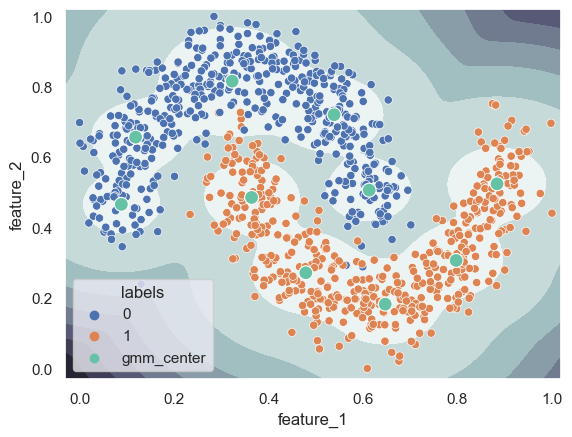

In [45]:
plt.contourf(x,y,z, cmap=plt.cm.bone)
moons_scatter()
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)

### Combine RBF and GMM centers

In [46]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [47]:
class TwoMoonsRBFNet(nn.Module):
    def __init__(self, centers=None, n_centers=10):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=n_centers,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True,
                           initial_centers_parameter=centers, # input gmm centers
                           constant_centers_parameter=True) # do not learn centers
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [48]:
lr = 0.1
decay = 5e-4

RBFnet = TwoMoonsRBFNet(centers=gmm.mu.data)
param_groups = [{'params':RBFnet.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)
rbf_tracker = [deepcopy(RBFnet.rbf)]
for epoch in range(150):
    loss,acc,_ = tt.train_plain(RBFnet.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    rbf_tracker.append(deepcopy(RBFnet.rbf)) # track each step to watch kernels in animation
    # if acc > .98:
    #     print('Done training at EPOCH:',epoch)
    #     break

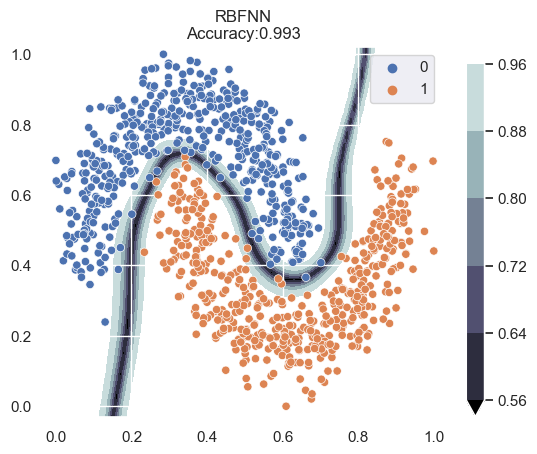

In [49]:
plot_conf(RBFnet, data, label, device=device, title='RBFNN')

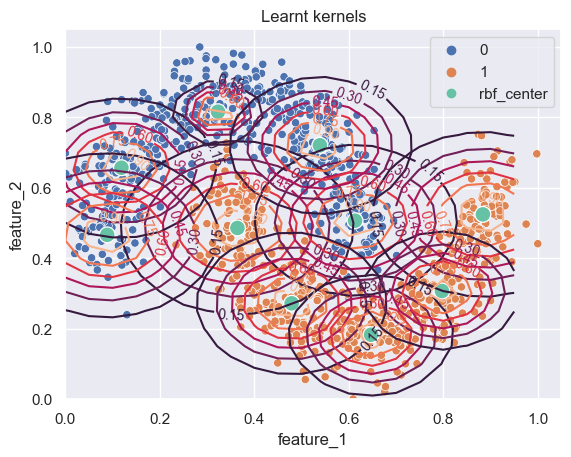

In [50]:
kernel_map(RBFnet.rbf, df)

In [51]:
%%skip True
animate_rbf(rbfs=rbf_tracker,
            df=df,
            title='_GMM_centers')

### Replace RBF outputs with GMM outputs

In [52]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [53]:
class RobustGMM(nn.Module):
    def __init__(self, gmm,  loglam=0, dim=2, classes=2):
        super().__init__()
        self.gmm = gmm
        self.dim = dim
        self.loglam = nn.Parameter(torch.tensor(loglam, dtype=torch.float), requires_grad=False)
        self.log_K = nn.Parameter(-torch.tensor(classes, dtype=torch.float).log(), requires_grad=False)
        self.fc1 = nn.Linear(gmm.mu.shape[0], classes) # pull number of centers down to binary class
        
    def forward(self, x):
        batch_size = x.shape[0]
        gmm_out = self.gmm(x.view(batch_size, self.dim)) # don't need activation (GMM is non-linear)
        like = torch.logsumexp(gmm_out, dim=0)
        x = self.fc1(gmm_out.T)
        x = F.log_softmax(x, dim=1) # output of (GMM/RBF)
        ## CCU on model output
        a1 = torch.stack((x + like[:, None], (self.loglam + self.log_K) * torch.ones_like(x)), 0)
        b1 = torch.logsumexp(a1, 0).squeeze()

        a2 = torch.stack((like, (self.loglam) * torch.ones_like(like)), 0)
        b2 = torch.logsumexp(a2, 0).squeeze()[:, None]

        return b1 - b2 
device=torch.device('cuda:0')

In [54]:
gmm.mu.requires_grad_(False) # turn of learning of centers
gmm.alpha.requires_grad_(False)
gmm.logvar.requires_grad_(False) 
Rgmm = RobustGMM(deepcopy(gmm))

In [55]:
lr = 0.01
decay = 5e-4


param_groups = [{'params':Rgmm.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)

for epoch in range(2000):
    loss,acc,_ = tt.train_plain(Rgmm.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    if epoch % 100 == 0:
        print(f'loss: {loss:.4f}\taccuracy: {acc:.3f}')
    if acc > .98:
        print('Done training at EPOCH:',epoch)
        break

loss: 0.0013	accuracy: 0.710
loss: 0.0007	accuracy: 0.866
loss: 0.0007	accuracy: 0.861
loss: 0.0007	accuracy: 0.858
loss: 0.0007	accuracy: 0.861
loss: 0.0007	accuracy: 0.859
loss: 0.0007	accuracy: 0.860
loss: 0.0007	accuracy: 0.861
loss: 0.0007	accuracy: 0.863
loss: 0.0007	accuracy: 0.853
loss: 0.0007	accuracy: 0.860
loss: 0.0007	accuracy: 0.862
loss: 0.0007	accuracy: 0.867
loss: 0.0007	accuracy: 0.861
loss: 0.0007	accuracy: 0.858
loss: 0.0007	accuracy: 0.861
loss: 0.0007	accuracy: 0.863
loss: 0.0007	accuracy: 0.856
loss: 0.0007	accuracy: 0.863
loss: 0.0007	accuracy: 0.862


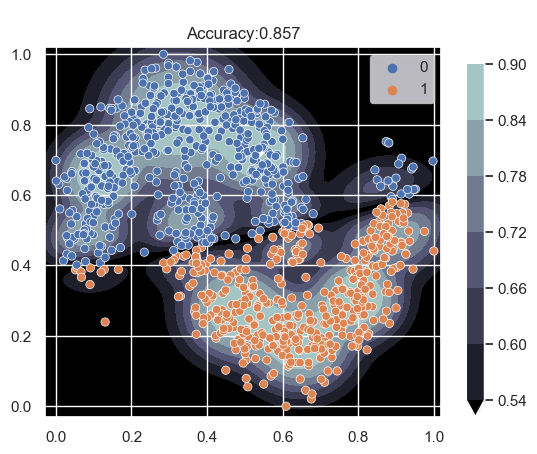

In [56]:
plot_conf(Rgmm, data, label, device=device)